# Pricing a path-dependent GMMB and Asian options in the Heston model.

The Heston model dynamic is:
$
ds_t = s_tr dt + s_t\sqrt{v_t}dw_t^1\\
dv_t = \kappa(\theta - v_t) dt + \sigma \sqrt{v_t}dw_t^2
$

with $dw_t^1dw_t^2=\rho dt$. We set $r=0$.

The price of the path-dependent GMMB is given by:

$
\mathbb{E}\left[\left(\left(\Pi_{i=0}^{k}s_{t_i}\right)^{\frac{1}{k+1}} -s_{t_k} \right)_+\right],
$

with $t_0=0<t_1<\ldots<t_k=T$.


The price of the Asian option is given by:

$
\mathbb{E}\left[\left( \frac{1}{T}\int_0^{T}s_udu - s_T \right)_+\right].
$


In [1]:
#Packages used to generate code below.

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Pricing functions for the path

# ----------------------------
# Heston Asian Option Pricing
# ----------------------------
def Heston_asian_option(
    s_0: float,
    v_0: float,
    r: float,
    kappa: float,
    theta: float,
    sigma: float,
    rho: float,
    num_MC: int,
    num_steps: int,
    T: float
) -> float:
    """
    Monte Carlo pricing of an Asian option under the Heston model.
    """
    np.random.seed(42)
    dt = T / num_steps
    sqrt_dt = math.sqrt(dt)
    payoff_sum = 0.0

    for _ in range(num_MC):
        ln_s = math.log(s_0)
        v = v_0
        spot_sum = 0.0

        for _ in range(num_steps):
            dw1 = np.random.normal() * sqrt_dt
            dw2 = rho * dw1 + math.sqrt(1 - rho**2) * np.random.normal() * sqrt_dt

            spot_sum += math.exp(ln_s) * dt
            ln_s += (r - 0.5 * v) * dt + math.sqrt(v) * dw1
            v += kappa * (theta - v) * dt + sigma * math.sqrt(v) * dw2

        avg_price = spot_sum / T
        final_price = math.exp(ln_s)
        payoff_sum += max(0.0, avg_price - final_price)

    return payoff_sum / num_MC

# -------------------------------------
# GMMB-like Option Pricing (Custom Payoff)
# -------------------------------------
def Heston_GMMB_option(
    s_0: float,
    v_0: float,
    r: float,
    kappa: float,
    theta: float,
    sigma: float,
    rho: float,
    num_MC: int,
    num_steps: int,
    T: float,
    k: int
) -> float:
    """
    Monte Carlo pricing of a path-dependent GMMB-like option under the Heston model.
    """
    np.random.seed(42)
    dt = T / num_steps
    sqrt_dt = math.sqrt(dt)
    payoff_sum = 0.0
    sample_interval = int(num_steps / k)

    for _ in range(num_MC):
        ln_s = math.log(s_0)
        v = v_0
        product_term = s_0
        sample_count = 1

        for i in range(1, num_steps + 1):
            dw1 = np.random.normal() * sqrt_dt
            dw2 = rho * dw1 + math.sqrt(1 - rho**2) * np.random.normal() * sqrt_dt

            if i % sample_interval == 0:
                product_term *= math.exp(ln_s)
                sample_count += 1

            ln_s += (r - 0.5 * v) * dt + math.sqrt(v) * dw1
            v += kappa * (theta - v) * dt + sigma * math.sqrt(v) * dw2

        final_price = math.exp(ln_s)
        avg_geom = product_term**(1 / sample_count)
        payoff_sum += max(0.0, avg_geom - final_price)

    return payoff_sum / num_MC

In [4]:
# -------------------------------------
# Simulation Parameters
# -------------------------------------
s_0 = 1.0                  # Initial stock price
v_0 = 0.2**2               # Initial variance
r = 0.0                    # Risk-free rate
kappa = 3.5                # Mean reversion speed
theta = 0.2**2             # Long-term variance
sigma = 0.2                # Vol of volatility
rho = -0.5                 # Correlation between asset and variance
T = 1.0                    # Time to maturity
num_MC = 50_000            # Number of Monte Carlo simulations
num_steps = 250            # Number of time steps
k = 5                      # Sampling parameter for GMMB-like option


Pricing of a GMMB option in the Heston model.


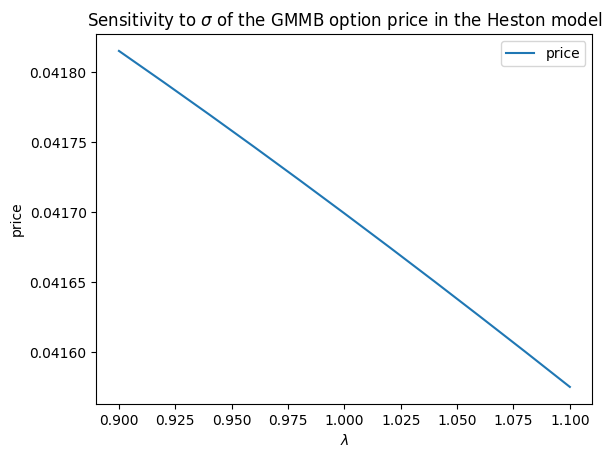

In [6]:
# -------------------------------------
# GMMB Option Sensitivity Plot
# -------------------------------------
print('Pricing of a GMMB option in the Heston model.')

sensitivity_gmmb = {}
for p in np.linspace(0.9, 1.1, num=11):
    sigma_scaled = p * sigma
    price = Heston_GMMB_option(s_0, v_0, r, kappa, theta, sigma_scaled, rho, num_MC, num_steps, T, k)
    sensitivity_gmmb[p] = price

df_gmmb = pd.DataFrame.from_dict(sensitivity_gmmb, orient='index', columns=['price'])
df_gmmb.plot(
    y='price',
    ylabel='price',
    xlabel=r'$\lambda$',
    use_index=True,
    title=r'Sensitivity to $\sigma$ of the GMMB option price in the Heston model'
)
plt.savefig("path_dependent_GMMB_option.pdf")
plt.show()

Pricing of an Asian option in the Heston model.


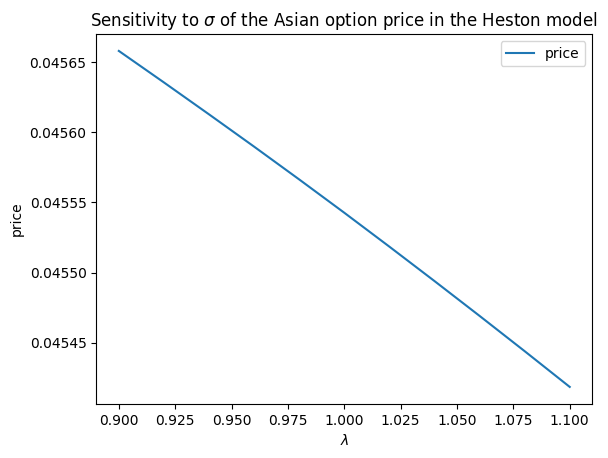

In [5]:
# -------------------------------------
# Asian Option Sensitivity Plot
# -------------------------------------
print('Pricing of an Asian option in the Heston model.')

sensitivity_asian = {}
for p in np.linspace(0.9, 1.1, num=11):
    sigma_scaled = p * sigma
    price = Heston_asian_option(s_0, v_0, r, kappa, theta, sigma_scaled, rho, num_MC, num_steps, T)
    sensitivity_asian[p] = price

df_asian = pd.DataFrame.from_dict(sensitivity_asian, orient='index', columns=['price'])
df_asian.plot(
    y='price',
    ylabel='price',
    xlabel=r'$\lambda$',
    use_index=True,
    title=r'Sensitivity to $\sigma$ of the Asian option price in the Heston model'
)
plt.savefig('asian_option.pdf')
plt.show()